## Taking a Look at 2017-18 Celitcs Game Data

Start with this function to pull all game data, which we figured out in [the Play-by-play notebook](Get Play-by-play.ipynb)

In [8]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

In [2]:
def fetch_game_data(year=None):
    'Fetch game-by-game data for all teams'
    all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]
    # Add a (simpler) season column, since SEASON_ID has a confusing first digit
    all_games['SEASON'] = all_games.SEASON_ID.str[-4:]
    # Limit by year
    if year is not None:
        all_games = all_games[all_games.SEASON == year]
    # Add a subseason column, indicating *regular season*, *playoffs*, *summer league*, *preseason*, or *other*
    def make_subseason(row):
        game_id_prefix = row['GAME_ID'][:2]
        season_id_prefix = row['SEASON_ID'][:1]
        if game_id_prefix == '00' and season_id_prefix == '1':
            return 'preseason'
        elif game_id_prefix == '00' and season_id_prefix == '2':
            return 'regular season'
        elif game_id_prefix == '00' and season_id_prefix == '4':
            return 'playoffs'
        elif game_id_prefix == '15' and season_id_prefix == '2':
            return 'summer league'
        else:
            return 'other'
    all_games['SUBSEASON'] = all_games.apply(make_subseason, axis=1)
    # Add a Points Against column.
    all_games['PTS_AGAINST'] = all_games.PTS - all_games.PLUS_MINUS
    return all_games

Data comes in with an "observation" of every team-game combination.
But some, maybe most, analyses will be at a game level and using both teams, so we need to reshape.

In [49]:
games_17 = fetch_game_data(year='2017')

In [50]:
# In the initial format, the unique key is TEAM_ID and GAME_ID. But for lots of analysis, you'd want each game to be an observation (row).
# Let's reshape it -- it's actually pretty easy.
def reshape_by_game(df):
    'Reshape game-by-game data so each game is an observation.'
    nice_df = pd.merge(df, df, how='inner', suffixes=('_A', '_B'),
                       on=('GAME_ID', 'SEASON_ID', 'GAME_DATE', 'SEASON', 'SUBSEASON'))
    nice_df = nice_df[nice_df.TEAM_ID_A != nice_df.TEAM_ID_B]
    return nice_df

In [51]:
games_17 = reshape_by_game(games_17)
print(games_17.shape)
games_17.head()

(4780, 57)


,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,PTS_A,...,OREB_B,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PLUS_MINUS_B,PTS_AGAINST_B
1,42017,1610612744,GSW,Golden State Warriors,0041700404,2018-06-08,GSW @ CLE,W,241,108,...,17,27,44,21,5,5,11,22,-23.0,108.0
2,42017,1610612739,CLE,Cleveland Cavaliers,0041700404,2018-06-08,CLE vs. GSW,L,242,85,...,10,34,44,25,7,13,8,24,23.0,85.0
5,42017,1610612739,CLE,Cleveland Cavaliers,0041700403,2018-06-06,CLE vs. GSW,L,240,102,...,6,31,37,27,6,5,10,20,8.0,102.0
6,42017,1610612744,GSW,Golden State Warriors,0041700403,2018-06-06,GSW @ CLE,W,239,110,...,15,32,47,20,6,4,13,18,-8.0,110.0
9,42017,1610612744,GSW,Golden State Warriors,0041700402,2018-06-03,GSW vs. CLE,W,238,122,...,16,26,42,25,9,4,10,15,-19.0,122.0


In [53]:
celtics_17 = games_17[(games_17.TEAM_ABBREVIATION_A == 'BOS') & (games_17.SUBSEASON == 'regular season')]
print('Pulled {} Celtics regular season games'.format(celtics_17.shape[0]))
celtics_17.head()

Pulled 82 Celtics regular season games


,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,PTS_A,...,OREB_B,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PLUS_MINUS_B,PTS_AGAINST_B
362,22017,1610612738,BOS,Boston Celtics,0021701219,2018-04-11,BOS vs. BKN,W,240,110,...,10,34,44,27,10,6,15,12,-13.0,110.0
378,22017,1610612738,BOS,Boston Celtics,0021701215,2018-04-10,BOS @ WAS,L,241,101,...,10,41,51,32,8,3,20,24,12.0,101.0
445,22017,1610612738,BOS,Boston Celtics,0021701202,2018-04-08,BOS vs. ATL,L,239,106,...,5,32,37,23,7,4,13,19,6.0,106.0
510,22017,1610612738,BOS,Boston Celtics,0021701185,2018-04-06,BOS vs. CHI,W,241,111,...,9,34,43,25,15,0,17,22,-7.0,111.0
577,22017,1610612738,BOS,Boston Celtics,0021701171,2018-04-04,BOS @ TOR,L,237,78,...,12,36,48,23,10,6,10,25,18.0,78.0


Is there a relationship between the number of 3s attempted and the points the Celtics score?

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

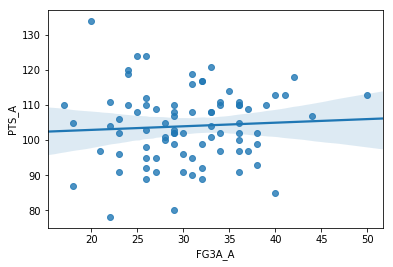

In [57]:
sns.regplot(celtics_17.FG3A_A, celtics_17.PTS_A);

Relationship between points scored by the Celts and points scored by their opponent?

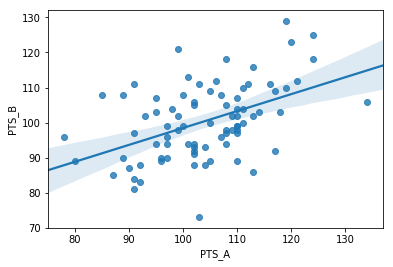

In [58]:
sns.regplot(celtics_17.PTS_A, celtics_17.PTS_B);

Yup.

Let's plot points for and against.

In [64]:
# Gotta reshape to get the points-for and points-against in different rows.
pts = celtics_17.melt(id_vars=['GAME_ID', 'GAME_DATE'],
                      value_vars=['PTS_A', 'PTS_B'],
                      value_name='PTS')
pts['FOR/AGAINST'] = pts['variable'].apply(lambda x: 'FOR' if x == 'PTS_A' else 'AGAINST')
pts.head()

,GAME_ID,GAME_DATE,variable,PTS,FOR/AGAINST
0,0021701219,2018-04-11,PTS_A,110,FOR
1,0021701215,2018-04-10,PTS_A,101,FOR
2,0021701202,2018-04-08,PTS_A,106,FOR
3,0021701185,2018-04-06,PTS_A,111,FOR
4,0021701171,2018-04-04,PTS_A,78,FOR


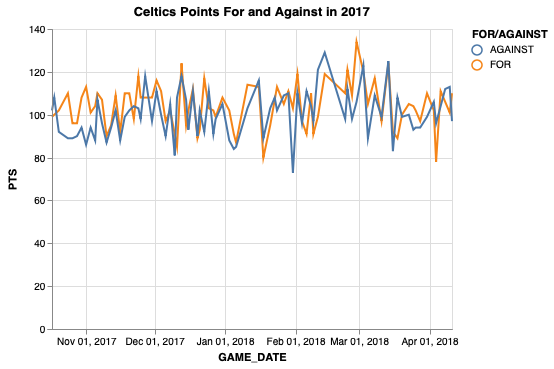

In [67]:
alt.Chart(pts).mark_line().encode(
    x='GAME_DATE:T',
    y='PTS',
    color='FOR/AGAINST'
).properties(
    title='Celtics Points For and Against in 2017'
)

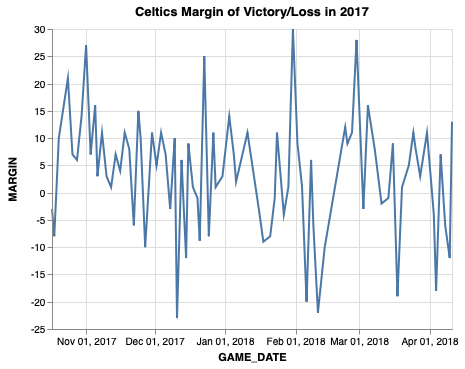

In [71]:
alt.Chart(celtics_17).mark_line().encode(
    x='GAME_DATE:T',
    y=alt.Y('PLUS_MINUS_A', title='MARGIN')
).properties(
    title='Celtics Margin of Victory/Loss in 2017'
)